<a href="https://colab.research.google.com/github/joaozz21/Teste_de_Hipoteses_Seguranca_de_Medicamentos/blob/main/Teste_de_Hip%C3%B3teses_na_%C3%81rea_da_Sa%C3%BAde_Seguran%C3%A7a_de_Medicamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste de Hipóteses na Área da Saúde: Segurança de Medicamentos

Uma empresa farmacêutica GlobalMed acabou de concluir um ensaio clínico controlado e randomizado. Para promover a transparência e reprodutibilidade dos resultados do medicamento, a GlobalMed apresentou o conjunto de dados à sua organização, uma entidade sem fins lucrativos especializada em segurança de medicamentos.

O conjunto de dados fornecido continha informações sobre cinco efeitos adversos, dados demográficos, sinais vitais, entre outros. Sua organização está principalmente interessada nas reações adversas ao medicamento. Deseja-se saber se estas reações, caso existam, são estatisticamente significativas. Você foi designado para explorar os dados e responder algumas questões específicas.

O conjunto de dados `drug_safety.csv` foi obtido do [Hbiostat](https://hbiostat.org/data/), cortesia do Departamento de Bioestatística da Universidade Vanderbilt. Ele incluía cinco efeitos adversos: dor de cabeça, dor abdominal, dispepsia, infecção do trato respiratório superior, doença pulmonar obstrutiva crônica (DPOC), além de dados demográficos, sinais vitais e medidas laboratoriais. A proporção entre observações do medicamento e do placebo é de 2 para 1.

Para este projeto, o conjunto de dados foi modificado para refletir a presença e ausência de efeitos adversos `adverse_effects` e o número de efeitos adversos em um único indivíduo `num_effects`.

As colunas no conjunto de dados modificado são:

| Coluna | Descrição |
|--------|-----------|
|`sex` | O gênero do indivíduo |
|`age` | A idade do indivíduo |
|`week` | A semana do teste do medicamento |
|`trx` | Os grupos de tratamento (Medicamento) e controle (Placebo) |
|`wbc` | A contagem de leucócitos |
|`rbc` | A contagem de hemácias |
|`adverse_effects` | A presença de pelo menos um efeito adverso |
|`num_effects` | O número de efeitos adversos experimentados por um único indivíduo |

O conjunto de dados original pode ser encontrado [aqui](https://hbiostat.org/data/repo/safety.rda).

Sua organização solicitou que você explorasse e respondesse algumas questões a partir dos dados coletados. Consulte as instruções do projeto.

In [4]:
# Importando libs
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando o dataset
drug_safety = pd.read_csv('https://raw.githubusercontent.com/joaozz21/Teste_de_Hipoteses_Seguranca_de_Medicamentos/refs/heads/main/drug_safety.csv')

# Começando o código...
drug_safety.head()

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


In [5]:
drug_safety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB


In [6]:
drug_safety.describe()

,age,week,wbc,rbc,num_effects
count,16103.000000,16103.00000,9128.000000,9127.000000,16103.000000
mean,64.117556,7.74098,7.340557,4.672784,0.101596
std,8.783207,6.94350,1.996652,0.458520,0.323181
min,39.000000,0.00000,1.800000,2.100000,0.000000
25%,58.000000,1.00000,6.000000,4.400000,0.000000
50%,65.000000,4.00000,7.100000,4.700000,0.000000
75%,71.000000,12.00000,8.400000,5.000000,0.000000
max,84.000000,20.00000,26.500000,7.600000,3.000000


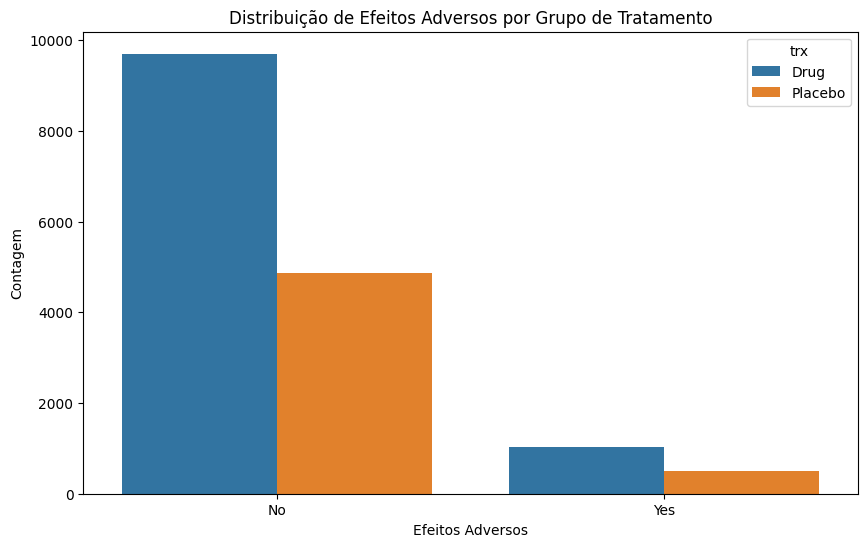

In [7]:
# Explorando a distribuição dos efeitos adversos por grupo de tratamento
plt.figure(figsize=(10, 6))
sns.countplot(x='adverse_effects', hue='trx', data=drug_safety)
plt.title('Distribuição de Efeitos Adversos por Grupo de Tratamento')
plt.xlabel('Efeitos Adversos')
plt.ylabel('Contagem')
plt.show()

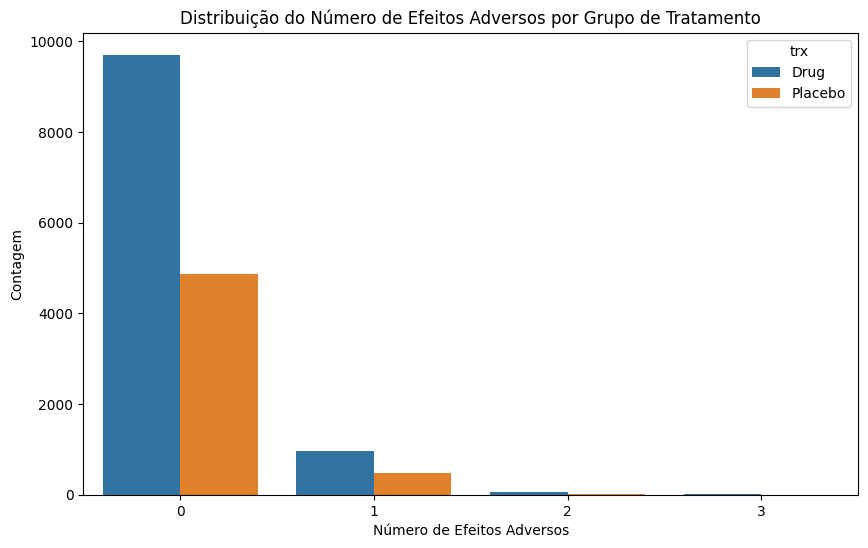

In [8]:
# Explorando a distribuição do número de efeitos adversos por grupo de tratamento
plt.figure(figsize=(10, 6))
sns.countplot(x='num_effects', hue='trx', data=drug_safety)
plt.title('Distribuição do Número de Efeitos Adversos por Grupo de Tratamento')
plt.xlabel('Número de Efeitos Adversos')
plt.ylabel('Contagem')
plt.show()

# **QUESTÃO 1:**
Determine se a proporção de efeitos adversos difere significativamente entre os grupos Medicamento e Placebo, salvando o valor-p como uma variável chamada **two_sample_p_value**.

Uma matriz de contingência serve como uma tabela que organiza sistematicamente os dados em categorias que se cruzam, fornecendo uma representação visual da distribuição combinada de duas variáveis categóricas. Ela se mostra particularmente valiosa ao explorar a inter-relação entre dois fatores qualitativos e investigar como as frequências dentro dessas categorias coincidem.

Nesta representação tabular, cada célula contém a contagem de observações que se enquadram em combinações específicas de categorias de variáveis. A matriz de contingência encontra ampla utilidade em análises estatísticas, notadamente em exames de independência e associação entre variáveis categóricas. Uma aplicação comum é o teste qui-quadrado, que avalia se duas variáveis categóricas exibem independência ou manifestam uma associação estatisticamente significativa.

In [9]:
# Criando uma tabela de contingência
contingency_table = pd.crosstab(drug_safety['trx'], drug_safety['adverse_effects'])

In [10]:
contingency_table

adverse_effects,No,Yes
trx,,
Drug,9703,1024
Placebo,4864,512


A execução de um teste z para proporções torna-se valiosa quando há necessidade de comparar as proporções de duas amostras e discernir se a diferença observada possui significância estatística. Esta abordagem de teste é comumente empregada quando se lida com variáveis binárias ou categóricas, especialmente quando o objetivo é avaliar se as proporções dessas categorias apresentam uma discrepância significativa entre dois grupos distintos.

In [11]:
# Executando um teste de proporção z
two_sample_proportions_test = sm.stats.proportions_ztest(contingency_table.iloc[:, 1], contingency_table.sum(axis=1))

In [12]:
# Imprimindo o resultado apenas para checar
two_sample_proportions_test

(0.0452182684494942, 0.9639333330262475)

In [13]:
# Extraindo o valor-p do resultado
two_sample_p_value = two_sample_proportions_test[1]

In [26]:
# Imprimindo o valor-p como requisitado
print(f"A proporção de efeitos adversos entre o grupo de drogas e placebo com valor-p é: {round(two_sample_p_value,2)}")

A proporção de efeitos adversos entre o grupo de drogas e placebo com valor-p é: 0.96


## **Conclusões**:

Um valor-p alto como 0,96 sugere que não há evidência estatística suficiente para rejeitar a hipótese nula de que as proporções são iguais. Por esta razão, a diferença observada pode ser devida ao acaso, e não há diferença significativa entre os grupos em termos de proporção de efeitos adversos com Placebo ou Medicamentos.

# Questão 2:
Descubra se o número de efeitos adversos é independente dos grupos de tratamento e controle, salvando como uma variável chamada num_effects_p_value contendo um valor-p.


Para determinar se o número de efeitos adversos é independente dos grupos de tratamento e controle, podemos usar o teste do "QUI-QUADRADO".


In [15]:
# Criando uma tabela de contingência entre 'trx' (ou seja, tratamento) e 'num_effects' (número de efeitos adversos)
contingency_table_num_effects = pd.crosstab(drug_safety['trx'], drug_safety['num_effects'])

In [16]:
# Checando os resultados da tabela
contingency_table_num_effects

num_effects,0,1,2,3
trx,,,,
Drug,9703,956,63,5
Placebo,4864,486,25,1


In [17]:
# Executando os testes de Qui-quadrado
chi2, num_effects_p_value, _, _ = chi2_contingency(contingency_table_num_effects)

In [28]:
# Checando os resultados
print(f"O valor-p do número independente de efeitos adversos dos grupos de tratamento e controle é: {round(num_effects_p_value,3)}")

O valor-p do número independente de efeitos adversos dos grupos de tratamento e controle é: 0.615


## **Conclusões:**

Com um valor-p de 0,6 -> como neste caso não foi escolhido o nível de significância, vamos usar 0,05 como o padrão na literatura. Neste caso, não há evidência estatística suficiente para rejeitar a hipótese nula. Portanto, não podemos afirmar uma associação significativa entre o número de efeitos adversos e os grupos de controle do tratamento.

Em outras palavras: isso implica que, podemos concluir com os testes estatísticos simples que não há indicação de que o tipo de tratamento (Medicamento ou Placebo) esteja ligado a um número distinto de efeitos adversos.

# **Questão 3:**

Examine se há uma diferença significativa entre as idades dos grupos de Medicamento e Placebo, armazenando o valor-p do seu teste em uma variável chamada **age_group_effects_p_value**.

In [19]:
# Extraindo a idade dos grupos de medicamento
age_drug = drug_safety[drug_safety['trx'] == 'Drug']['age']
age_drug.head()

,age
0,62
1,62
2,62
3,62
4,62


In [20]:
# Extraindo a idade do grupo placebo
age_placebo = drug_safety[drug_safety['trx'] == 'Placebo']['age']
age_placebo.head()

,age
32,73
33,73
34,73
35,73
36,73


# Teste-T

Para este contexto, o Teste-T pode ser usado para determinar se há uma diferença significativa entre as idades dos grupos de Medicamento e Placebo. Este tipo de teste é útil quando estamos trabalhando com variáveis contínuas, como 'idades' nesta questão, para comparar as médias de dois grupos independentes e entender se há diferença estatística significativa ou não.

In [21]:
# Executando teste-T
t_stat, age_group_effects_p_value = ttest_ind(age_drug, age_placebo, nan_policy='omit')

In [29]:
# Checando os resultados
print(f"Valor-p para significância entre os grupos de Medicamento e Placebo: {round(age_group_effects_p_value,3)}")

Valor-p para significância entre os grupos de Medicamento e Placebo: 0.138


## Conclusão:

O valor-p é 0.13, que é maior que o nível de significância que estamos usando neste caso (0.05). Portanto, não há evidência estatística suficiente para rejeitar a hipótese nula também.

Não podemos afirmar que há uma diferença significativa entre as idades dos Grupos de Medicamentos e Placebo. Podemos concluir que cada caso deve ser estudado individualmente, já que não há evidência suficiente para concluir o contrário.